Студент: Кирилл Кривушин


# Домашка 
---------------------------------------


tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

---




## <font color='green'> Для домашней работы я выбрал Neural Style Transfer</font>
1. За основу взята архитектуры сети и код из семинара по соотвествующей теме.
2. Модифицируем код для разделения картинки на две части и переноса на них разных стилей. 


## Neural Style Transfer, опиция 1

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import os

import torchvision.transforms as transforms
import torchvision.models as models

import copy

### Загрузка изображений

In [80]:
%%bash
mkdir -p  /data/images/neural-style/

wget 'https://www.gannett-cdn.com/presto/2019/01/31/USAT/da32117d-62b0-497b-b40b-e36c8163e3da-universe.jpg?width=1320&height=748&fit=crop&format=pjpg&auto=webp' \
  -O /data/images/neural-style/space.jpg
wget 'http://www.eiidirect.com/wp-content/uploads/2016/03/Yuri-Gagrin.jpg' \
  -O /data/images/neural-style/gagarin.jpg

wget 'https://images.squarespace-cdn.com/content/v1/5506e67ce4b0fe6c8e8ebd94/1428090579868-4F55GPR3H9N9IX3PTXCS/ke17ZwdGBToddI8pDm48kBAUZpPlpL46D9DHrMhg54VZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpxuZdumU8GItHHyqfca5zY4Z8LPW3G0H7g3iyyvMTnekKU8fr6nvIEKMLeWzzoCxlU/picasso-portrait-of-the-artist-collotype-fine-art-print.jpg?format=1500w' \
  -O /data/images/neural-style/picasso.jpg

wget 'https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg' \
  -O /data/images/neural-style/dancing.jpg

wget 'https://allrus.me/wp-content/uploads/2014/06/Mistress-of-Copper-Mountain-2007.jpg' \
  -O /data/images/neural-style/shishkin.jpg

wget 'https://www.gustavklimt.net/Church%20in%20Cassone%20Gustav%20Klimt.jpg' \
  -O /data/images/neural-style/klimt.jpg

wget 'https://www.antiquesandthearts.com/wp-content/uploads/2019/10/Claude-Monet-Waterlilies-and-Japanese-Bridge-1899_HIGH-RES.jpg' \
  -O /data/images/neural-style/monet.jpg

wget 'https://images.squarespace-cdn.com/content/v1/5ccb15ca0b77bdbb3acbf0f4/1556815187275-UYM2YXV9EIZWC6ZF1P4F/ke17ZwdGBToddI8pDm48kIOQOGU1kBVzo3QZC2XTQFN7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UXKpaa60E0fzFuSh4q1_ZhXdvkH-lnup9Fk-yC09NNBcTCgV58CQKqkVi4LppNMUzA/online+1.jpg?format=1000w' \
 -O /data/images/neural-style/cubism.jpg

wget 'https://i.pinimg.com/originals/b2/6c/b1/b26cb17470578ec9bc449b9c3f03608b.jpg' \
  -O /data/images/neural-style/micro.jpg

wget 'https://image.freepik.com/free-vector/monochrome-reaction-diffusion-seamless-pattern_150500-503.jpg' \
  -O /data/images/neural-style/facets.jpg

wget 'https://www.xacto.com/sites/g/files/zutxbn281/files/styles/inline/public/externals/020a29c5606f6e95d63e70fea9c20dee.jpg?itok=c6-xtvKu' \
 -O /data/images/neural-style/mosaic.jpg

wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1280px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg' \
 -O /data/images/neural-style/mona_lisa.jpg

wget 'https://i2.wp.com/followthecolours.com.br/wp-content/uploads/2014/01/follow-the-colours-fabian-oefner-Millefiori-05.png?ssl=1' \
  -O /data/images/neural-style/ferofluids.jpg

wget 'https://raw.githubusercontent.com/luanfujun/deep-photo-styletransfer/master/examples/input/in3.png' \
  -O /data/images/neural-style/city_day.jpg

wget 'https://raw.githubusercontent.com/luanfujun/deep-photo-styletransfer/master/examples/style/tar4.png' \
  -O /data/images/neural-style/city_night.jpg

--2021-01-17 05:14:16--  https://www.gannett-cdn.com/presto/2019/01/31/USAT/da32117d-62b0-497b-b40b-e36c8163e3da-universe.jpg?width=1320&height=748&fit=crop&format=pjpg&auto=webp
Resolving www.gannett-cdn.com (www.gannett-cdn.com)... 151.101.2.62, 151.101.66.62, 151.101.130.62, ...
Connecting to www.gannett-cdn.com (www.gannett-cdn.com)|151.101.2.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344861 (337K) [image/jpeg]
Saving to: ‘/data/images/neural-style/space.jpg’

     0K .......... .......... .......... .......... .......... 14% 28.9M 0s
    50K .......... .......... .......... .......... .......... 29% 30.9M 0s
   100K .......... .......... .......... .......... .......... 44% 54.7M 0s
   150K .......... .......... .......... .......... .......... 59% 33.5M 0s
   200K .......... .......... .......... .......... .......... 74% 56.6M 0s
   250K .......... .......... .......... .......... .......... 89% 31.9M 0s
   300K .......... .......... .......... 

In [81]:
imsize = 512  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


Выведем то, что было загружено

In [83]:


pics_folder = '/data/images/neural-style'


pics = [f"{pics_folder}/{i}" for i in os.listdir(pics_folder) if i.endswith('.jpg')]
pics

['/data/images/neural-style/mona_lisa.jpg',
 '/data/images/neural-style/cubism.jpg',
 '/data/images/neural-style/gagarin.jpg',
 '/data/images/neural-style/monet.jpg',
 '/data/images/neural-style/city_night.jpg',
 '/data/images/neural-style/mosaic.jpg',
 '/data/images/neural-style/picasso.jpg',
 '/data/images/neural-style/klimt.jpg',
 '/data/images/neural-style/city_day.jpg',
 '/data/images/neural-style/shishkin.jpg',
 '/data/images/neural-style/ferofluids.jpg',
 '/data/images/neural-style/facets.jpg',
 '/data/images/neural-style/micro.jpg',
 '/data/images/neural-style/dancing.jpg',
 '/data/images/neural-style/space.jpg']

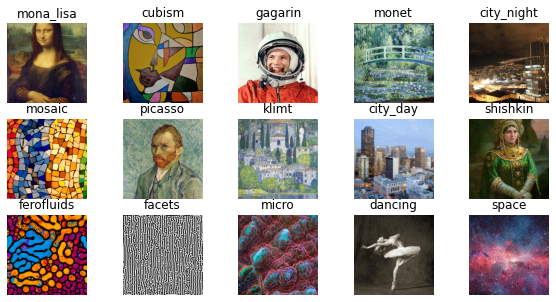

In [84]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    # plt.pause(0.001) # pause a bit so that plots are updated

npics = len(pics)
ncols = 5
nrows = npics // ncols
if npics % ncols >0:
  nrows += 1


plt.figure(figsize=(10,5))
for i in range(npics):
  pic = pics[i]
  pic_name = pic.split('/')[-1]
  plt.subplot(nrows,ncols,i+1)
  imshow(image_loader(pic), title=pic_name.split('.')[0])
  plt.axis('off')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

### ContentLoss

In [85]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />
Полное понимание этого момента можно получить с помощью [этого](https://arxiv.org/pdf/1508.06576.pdf)  и [этого](https://m.habr.com/company/mailru/blog/306916/).

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />


### gram_matrix

In [86]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE

In [87]:
# class StyleLoss(nn.Module):
#         def __init__(self, target_feature):
#             super(StyleLoss, self).__init__()
#             self.target = gram_matrix(target_feature).detach()
#             self.loss = F.mse_loss(self.target, self.target)# to initialize with something

#         def forward(self, input):
#             G = gram_matrix(input)
#             self.loss = F.mse_loss(G, self.target)
#             return input

### StyleLoss

 <font color='green'> Переопределим `Style loss` для задачи переноса двух стилей на левуй и правую часть каритники по отдельности</font>

In [88]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature1, target_feature2):
        super(StyleLoss, self).__init__()
        
        input_size = target_feature1.size()
        self.mask1 = torch.ones(1, input_size[1], input_size[2], input_size[3]).to(device)
        self.mask2 = torch.ones(1, input_size[1], input_size[2], input_size[3]).to(device)
        self.mask1[:, :, :, :input_size[2]//2] = 0
        self.mask2[:, :, :, input_size[2]//2:] = 0

        self.target1 = gram_matrix(target_feature1*self.mask1)#.detach()
        self.target2 = gram_matrix(target_feature2*self.mask2)#.detach()

    def forward(self, input):
        input1 = self.mask1*input
        input2 = self.mask2*input

        G = gram_matrix(input1)
        G2 = gram_matrix(input2)
        self.loss = (F.mse_loss(G, self.target1),
                     F.mse_loss(G2, self.target2))

        return input 

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [89]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [90]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и  функции потерь 

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [91]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Определим предобученную модель

In [92]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [93]:
# def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
#                                    style_img, content_img,
#                                    content_layers=content_layers_default,
#                                    style_layers=style_layers_default):
#         cnn = copy.deepcopy(cnn)

#         # normalization module
#         normalization = Normalization(normalization_mean, normalization_std).to(device)

#         # just in order to have an iterable access to or list of content/syle
#         # losses
#         content_losses = []
#         style_losses = []

#         # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
#         # to put in modules that are supposed to be activated sequentially
#         model = nn.Sequential(normalization)

#         i = 0  # increment every time we see a conv
#         for layer in cnn.children():
#             if isinstance(layer, nn.Conv2d):
#                 i += 1
#                 name = 'conv_{}'.format(i)
#             elif isinstance(layer, nn.ReLU):
#                 name = 'relu_{}'.format(i)
#                 # The in-place version doesn't play very nicely with the ContentLoss
#                 # and StyleLoss we insert below. So we replace with out-of-place
#                 # ones here.
#                 #Переопределим relu уровень
#                 layer = nn.ReLU(inplace=False)
#             elif isinstance(layer, nn.MaxPool2d):
#                 name = 'pool_{}'.format(i)
#             elif isinstance(layer, nn.BatchNorm2d):
#                 name = 'bn_{}'.format(i)
#             else:
#                 raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

#             model.add_module(name, layer)

#             if name in content_layers:
#                 # add content loss:
#                 target = model(content_img).detach()
#                 content_loss = ContentLoss(target)
#                 model.add_module("content_loss_{}".format(i), content_loss)
#                 content_losses.append(content_loss)

#             if name in style_layers:
#                 # add style loss:
#                 target_feature = model(style_img).detach()
#                 style_loss = StyleLoss(target_feature)
#                 model.add_module("style_loss_{}".format(i), style_loss)
#                 style_losses.append(style_loss)

#         # now we trim off the layers after the last content and style losses
#         #выбрасываем все уровни после последенего styel loss или content loss
#         for i in range(len(model) - 1, -1, -1):
#             if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
#                 break

#         model = model[:(i + 1)]

#         return model, style_losses, content_losses

### get_style_model_and_losses

<font color='green'>Также переопределим функцию `get_style_model_and_losses()`</font>

In [94]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, style_img2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    style_losses2 = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            target_feature2 = model(style_img2).detach()
            style_loss = StyleLoss(target_feature, target_feature2)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [95]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [96]:
# def run_style_transfer(cnn, normalization_mean, normalization_std,
#                         content_img, style_img, input_img, num_steps=500,
#                         style_weight=100000, content_weight=1):
#         """Run the style transfer."""
#         print('Building the style transfer model..')
#         model, style_losses, content_losses = get_style_model_and_losses(cnn,
#             normalization_mean, normalization_std, style_img, content_img)
#         optimizer = get_input_optimizer(input_img)

#         print('Optimizing..')
#         run = [0]
#         while run[0] <= num_steps:

#             def closure():
#                 # correct the values 
#                 # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
#                 input_img.data.clamp_(0, 1)

#                 optimizer.zero_grad()

#                 model(input_img)

#                 style_score = 0
#                 content_score = 0

#                 for sl in style_losses:
#                     style_score += sl.loss
#                 for cl in content_losses:
#                     content_score += cl.loss
                
#                 #взвешивание ощибки
#                 style_score *= style_weight
#                 content_score *= content_weight

#                 loss = style_score + content_score
#                 loss.backward()

#                 run[0] += 1
#                 if run[0] % 50 == 0:
#                     print("run {}:".format(run))
#                     print('Style Loss : {:4f} Content Loss: {:4f}'.format(
#                         style_score.item(), content_score.item()))
#                     print()

#                 return style_score + content_score

#             optimizer.step(closure)

#         # a last correction...
#         input_img.data.clamp_(0, 1)

#         return input_img

### run_style_transfer

<font color='green'> Немного поправим `run_style_transfer()`</font>

In [97]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, style_img2, input_img, num_steps=300,
                       style_weight=10000, style_weight2=10000, content_weight=10):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                    normalization_mean, 
                                                                    normalization_std, 
                                                                    style_img, 
                                                                    style_img2, 
                                                                    content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            style_score2 = 0
            content_score = 0

            for style_loss in style_losses:
                sl,sl2 = style_loss.loss
                style_score += sl
                style_score2 += sl2

            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            style_score2 *= style_weight2
            content_score *= content_weight

            loss = style_score + style_score2 + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss: {:4f}, Style Loss 2: {:4f}, Content Loss: {:4f}'.format(
                    style_score.item(), style_score2.item(), content_score.item()))
                print()

            return style_score + style_score2 + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### <font color='green'> Запустим пару тестов для проверки пеерноса стилей разные половины изображения.

In [98]:
space = image_loader(f"{pics_folder}/space.jpg")
micro = image_loader(f"{pics_folder}/micro.jpg")
dance = image_loader(f"{pics_folder}/dancing.jpg")
monet = image_loader(f"{pics_folder}/monet.jpg")
monalisa = image_loader(f"{pics_folder}/mona_lisa.jpg")
cubism = image_loader(f"{pics_folder}/cubism.jpg")
picasso = image_loader(f"{pics_folder}/picasso.jpg")

shishkin = image_loader(f"{pics_folder}/shishkin.jpg")
facets = image_loader(f"{pics_folder}/facets.jpg")
fluids = image_loader(f"{pics_folder}/ferofluids.jpg")
mosaic = image_loader(f"{pics_folder}/mosaic.jpg")
gagarin = image_loader(f"{pics_folder}/gagarin.jpg")
klimt = image_loader(f"{pics_folder}/klimt.jpg")

city = image_loader(f"{pics_folder}/city_day.jpg")

Определим функцию для запуска модкли и вывода результатов


In [99]:
def run_view(content_img,style_img,style_img2, figsize=(10,10), num_steps=400,
             style_weight=100000, style_weight2=100000, content_weight=1):

  input_img = torch.randn(content_img.data.size(), device=device)

  cnn = models.vgg19(pretrained=True).features.to(device).eval()

  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                              content_img, 
                              style_img, style_img2, 
                              input_img, num_steps,
                              style_weight, style_weight2, content_weight)


  plt.figure(figsize=figsize)
  plt.subplot(2,2,1)
  imshow(content_img, title='Input Image')
  plt.axis('off')
  plt.subplot(2,2,2)
  imshow(output, title='Output Image')
  plt.axis('off')
  plt.subplot(2,2,3)
  imshow(style_img2, title='Style2 Image')
  plt.axis('off')
  plt.subplot(2,2,4)
  imshow(style_img, title='Style1 Image')
  plt.axis('off')
  None
  
  return("Plot is ready")

In [100]:
figsize=(10,10)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss: 42.430466, Style Loss 2: 2.443630, Content Loss: 36.791008

run [100]:
Style Loss: 10.798384, Style Loss 2: 1.121717, Content Loss: 29.274811

run [150]:
Style Loss: 4.472187, Style Loss 2: 0.918889, Content Loss: 24.314428

run [200]:
Style Loss: 2.611198, Style Loss 2: 0.785994, Content Loss: 21.219051

run [250]:
Style Loss: 1.841811, Style Loss 2: 0.787276, Content Loss: 19.159292

run [300]:
Style Loss: 1.578471, Style Loss 2: 0.770618, Content Loss: 17.888186



'Plot is ready'

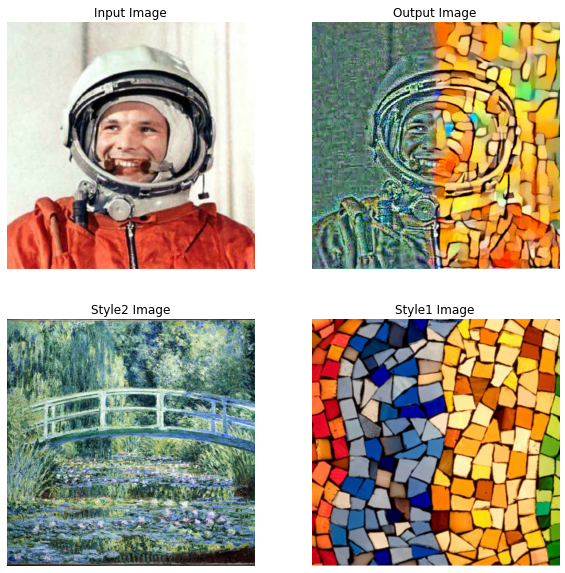

In [101]:
content_img=gagarin
style_img=mosaic
style_img2=monet

run_view(content_img, style_img, style_img2, 
         figsize, num_steps=300,
         style_weight=100000, style_weight2=10000, content_weight=1)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss: 9.348989, Style Loss 2: 2.872246, Content Loss: 18.776678

run [100]:
Style Loss: 3.486970, Style Loss 2: 1.506238, Content Loss: 10.569889

run [150]:
Style Loss: 1.884351, Style Loss 2: 1.012253, Content Loss: 7.824799

run [200]:
Style Loss: 1.330870, Style Loss 2: 0.750092, Content Loss: 6.624858

run [250]:
Style Loss: 1.246001, Style Loss 2: 0.582454, Content Loss: 6.053299

run [300]:
Style Loss: 1.017706, Style Loss 2: 0.471011, Content Loss: 5.719702

run [350]:
Style Loss: 0.986144, Style Loss 2: 0.440020, Content Loss: 5.603160

run [400]:
Style Loss: 1.856763, Style Loss 2: 0.695078, Content Loss: 5.821597



'Plot is ready'

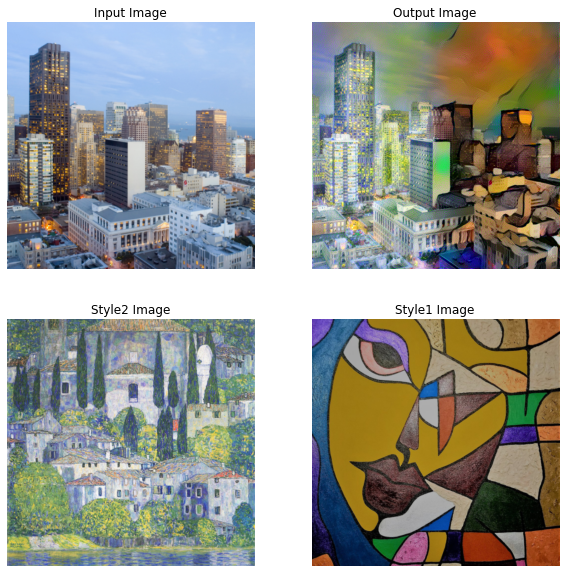

In [102]:
content_img=city
style_img=cubism
style_img2=klimt

run_view(content_img, style_img, style_img2, 
         figsize, num_steps=400,
         style_weight=100000, style_weight2=100000, content_weight=1)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss: 4.125877, Style Loss 2: 2.259465, Content Loss: 21.119987

run [100]:
Style Loss: 1.841746, Style Loss 2: 1.092607, Content Loss: 15.583286

run [150]:
Style Loss: 1.138951, Style Loss 2: 0.711795, Content Loss: 13.135353

run [200]:
Style Loss: 0.785481, Style Loss 2: 0.539575, Content Loss: 12.063388

run [250]:
Style Loss: 0.578639, Style Loss 2: 0.521508, Content Loss: 11.502576

run [300]:
Style Loss: 0.455798, Style Loss 2: 0.475368, Content Loss: 11.231512

run [350]:
Style Loss: 0.397886, Style Loss 2: 0.452997, Content Loss: 11.087093

run [400]:
Style Loss: 0.382764, Style Loss 2: 0.474430, Content Loss: 11.011139



'Plot is ready'

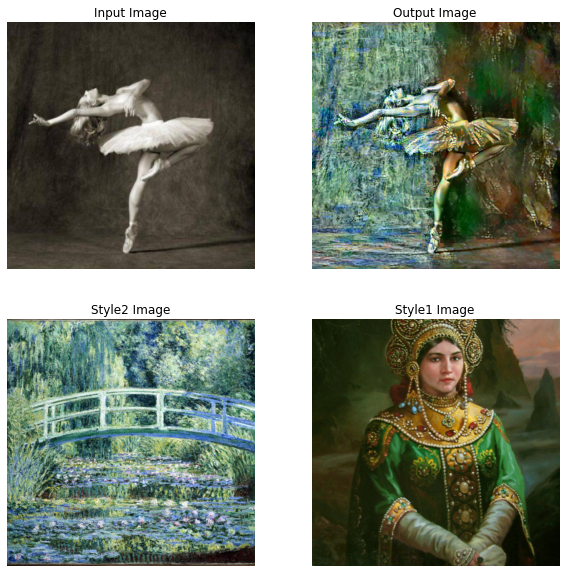

In [103]:
content_img=dance
style_img=shishkin
style_img2=monet

run_view(content_img, style_img, style_img2, 
         figsize, num_steps=400,
         style_weight=100000, style_weight2=100000, content_weight=1)
         

## Neural Style Transfer, опиция 2

### <font color='green'> Немного поправим `StyleLoss` и get_style_model_and_losses для одновеременного переносы двух стилей
</font>

---



In [104]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        # if target_feature2:
        # self.target2 = gram_matrix(target_feature2).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        # if self.target2:
        # self.loss = self.loss + F.mse_loss(G)
        return input

In [105]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, style_img2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    style_losses2 = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            # if style_img2:
            target_feature2 = model(style_img2).detach()
            style_loss = StyleLoss(target_feature)
            style_loss2 = StyleLoss(target_feature2)
            model.add_module("style_loss_{}".format(i), style_loss)
            model.add_module("style_loss2_{}".format(i), style_loss2)
            style_losses.append(style_loss)
            style_losses2.append(style_loss2)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, style_losses2, content_losses

In [106]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, style_img2, input_img, num_steps=300,
                       style_weight=10000, style_weight2=10000, content_weight=10):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, style_losses2, content_losses = get_style_model_and_losses(cnn,
                                                                    normalization_mean, 
                                                                    normalization_std, 
                                                                    style_img, 
                                                                    style_img2, 
                                                                    content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            style_score2 = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for sl2 in style_losses2:
                style_score2 += sl2.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            style_score2 *= style_weight2
            content_score *= content_weight

            loss = style_score + style_score2 + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 396.643158 Content Loss: 86.663422

run [100]:
Style Loss : 386.588562 Content Loss: 49.052399

run [150]:
Style Loss : 383.726318 Content Loss: 40.991661

run [200]:
Style Loss : 382.128021 Content Loss: 38.146935

run [250]:
Style Loss : 382.561646 Content Loss: 36.843933

run [300]:
Style Loss : 382.445892 Content Loss: 36.167046



'Plot is ready'

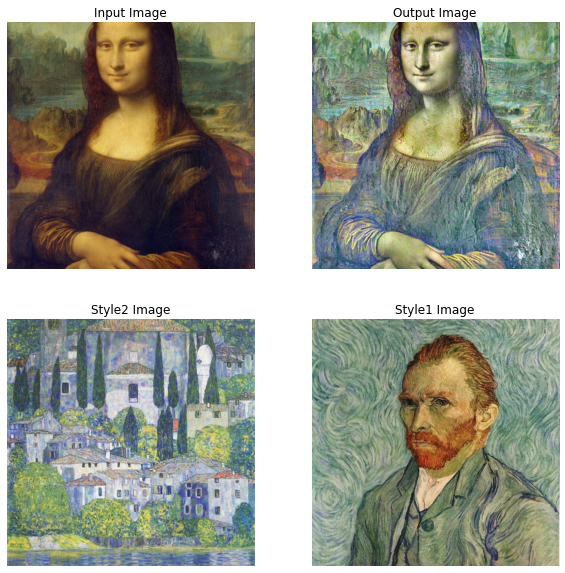

In [107]:
content_img=monalisa
style_img=picasso
style_img2=klimt

run_view(content_img, style_img, style_img2, 
         figsize, num_steps=300,
         style_weight=100000, style_weight2=100000, content_weight=10)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 306.361023 Content Loss: 230.919617

run [100]:
Style Loss : 315.669464 Content Loss: 147.476028

run [150]:
Style Loss : 271.217468 Content Loss: 193.578339

run [200]:
Style Loss : 323.043304 Content Loss: 140.316162

run [250]:
Style Loss : 277.566467 Content Loss: 188.857391

run [300]:
Style Loss : 25165.625000 Content Loss: 1914.700317



'Plot is ready'

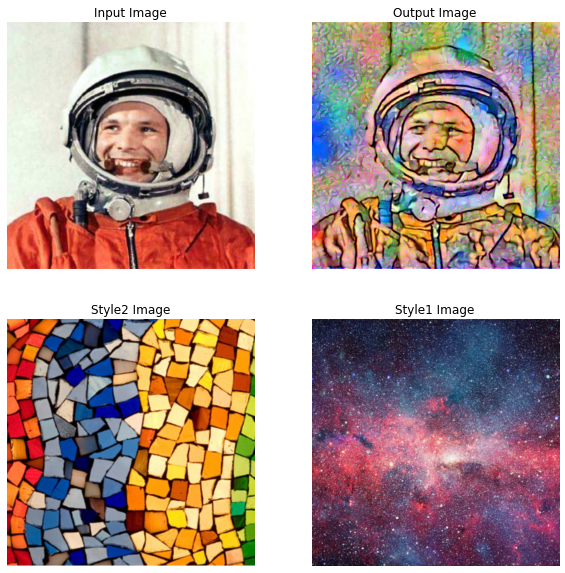

In [108]:
content_img=gagarin
style_img=space
style_img2=mosaic

run_view(content_img, style_img, style_img2, 
         figsize, num_steps=300,
         style_weight=10000, style_weight2=100000, content_weight=10)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 408.595612 Content Loss: 29.036880

run [100]:
Style Loss : 374.180939 Content Loss: 18.851984

run [150]:
Style Loss : 368.105286 Content Loss: 13.122246

run [200]:
Style Loss : 358.885681 Content Loss: 9.929367

run [250]:
Style Loss : 362.217834 Content Loss: 8.217272

run [300]:
Style Loss : 359.880859 Content Loss: 7.061561

run [350]:
Style Loss : 360.357849 Content Loss: 6.382563

run [400]:
Style Loss : 360.667725 Content Loss: 5.890088



'Plot is ready'

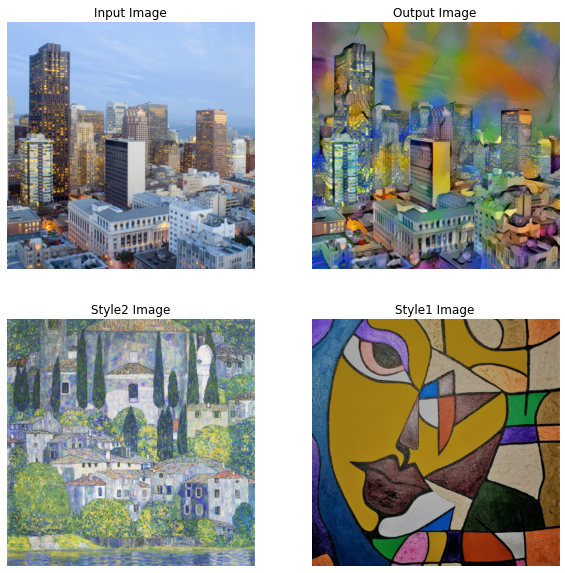

In [109]:
content_img=city
style_img=cubism
style_img2=klimt


run_view(content_img, style_img, style_img2, 
         figsize, num_steps=400,
         style_weight=100000, style_weight2=100000, content_weight=1)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 123.500984 Content Loss: 19.004318

run [100]:
Style Loss : 103.428596 Content Loss: 14.854523

run [150]:
Style Loss : 100.501999 Content Loss: 12.439274

run [200]:
Style Loss : 98.672310 Content Loss: 10.920140

run [250]:
Style Loss : 98.015434 Content Loss: 9.912233

run [300]:
Style Loss : 98.058746 Content Loss: 9.249631

run [350]:
Style Loss : 97.626205 Content Loss: 8.839231

run [400]:
Style Loss : 97.101318 Content Loss: 8.557245



'Plot is ready'

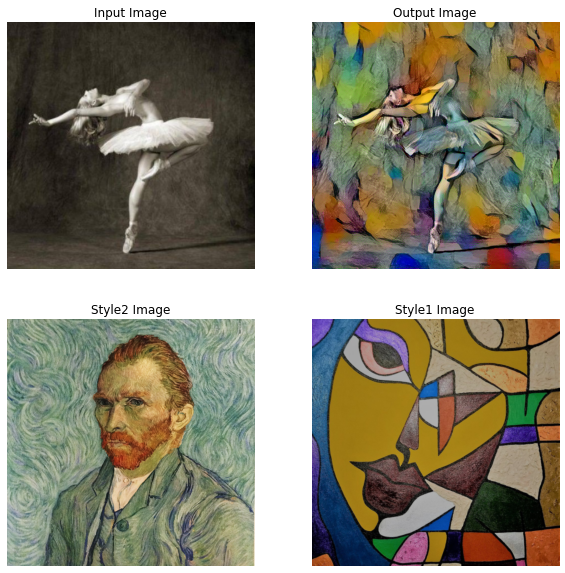

In [110]:
content_img=dance
style_img=cubism
style_img2=picasso

run_view(content_img, style_img, style_img2, 
         figsize, num_steps=400,
         style_weight=100000, style_weight2=100000, content_weight=1)